In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosave disabled


# truckvotes

In [2]:
from truckvotes import *

## read data from CSV files

In [3]:
people = read_people(2008)
people.nlargest(5)

State
CA    36756666.0
TX    24326974.0
NY    19490297.0
FL    18328340.0
IL    12901563.0
Name: people, dtype: float64

In [4]:
trucks = read_trucks(2008)
trucks.nlargest(5)

State
TX    4161931.0
CA    4029168.0
FL    2170063.0
GA    1687071.0
OH    1550255.0
Name: trucks, dtype: float64

In [5]:
votes = read_votes(2008)
votes.nlargest(5,'red')

,blue,red,green
State,,,
CA,8274473.0,5011781.0,275646.0
TX,3528633.0,4479328.0,69834.0
FL,4282074.0,4045624.0,63046.0
NY,4804945.0,2752771.0,83215.0
OH,2940044.0,2677820.0,90486.0


## inspect data

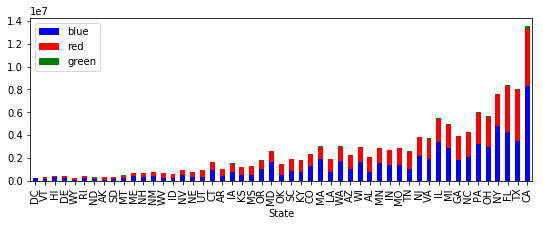

In [9]:
bar_votes(votes)

{'slope': 1.238,
 'intercept': 200632.1586,
 'rvalue': 0.9052,
 'pvalue': 0.0,
 'stderr': 0.083}

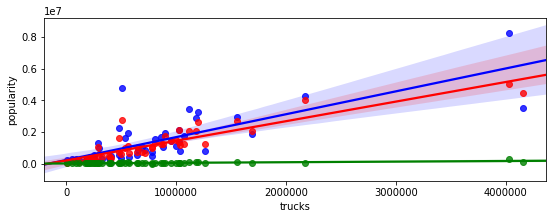

In [10]:
scatter_votes(trucks,votes)
regression(trucks,votes['red'])

## (truckdensity,redfrac)

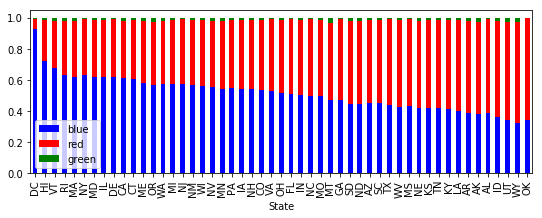

In [11]:
numvotes = votes.sum(axis=1)
votefrac = votes.apply(lambda x: x/numvotes)
bar_votes(votefrac)

{'slope': 0.8676,
 'intercept': 0.3286,
 'rvalue': 0.6574,
 'pvalue': 0.0,
 'stderr': 0.1421}

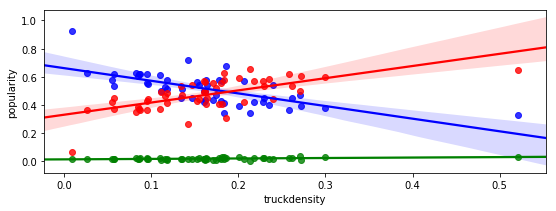

In [12]:
truckdensity = (trucks/people).rename('truckdensity')
scatter_votes(truckdensity,votefrac)
regression(truckdensity,votefrac['red'])

## (truckness,redness)

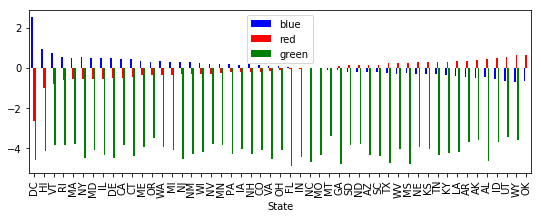

In [13]:
voteness = votefrac.apply(logit)
bar_votes(voteness,stacked=False)

{'slope': 1.4681,
 'intercept': 1.1126,
 'rvalue': 0.7747,
 'pvalue': 0.0,
 'stderr': 0.1712}

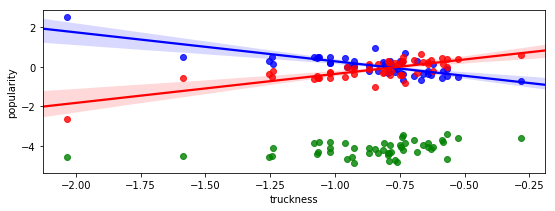

In [14]:
truckness = log10(truckdensity).rename('truckness')
scatter_votes(truckness,voteness)
regression(truckness,voteness['red'])

In [ ]:
assert False

<h2>Plot the predictor and target variable</h2>

The (silly) idea is to use the popularity of pickup trucks in a state to predict Republican/Democratic popularity. Define a predictor and a target:
<ul>
<li><b>Truckness</b> = number of new pickup truck registrations in 2008 per capita
<li><b>RedPct</b> = fraction of <i>non-third-party</i> voters who voted Republican
</ul>

Align Truckness and RedPct in a DataFrame called <b>TruckVotes</b>. For plotting purposes, append Population and sort by Truckness. Check for missing or mis-aligned data, then scatterplot Truckness vs RedPct. Scale dots by population size, and color them by RedPct.

<h2>Linear regression</h2>

<b>Ordinary least-squares linear regression</b> assumes a linear$^1$ model:

$$
R_j = \alpha + \beta T_j + \epsilon_j
$$

where $R_j$ is RedPct of the $j$th sample, $T_j$ is its Truckness, $\alpha, \beta$ are two real constants to be determined, and the <b>error terms</b> $\{ \epsilon_j \}$ are random variables. Assume the errors $\epsilon_j$ are all independent, normally-distributed, have the same variance, and have mean 0. Under these (unrealistic) assumptions, the maximum-likelihood estimates of $\alpha$ and $\beta$ are whatever values minimize the total square error:

$$
\sum_{j=0}^{50} \epsilon^2 = \sum_{j=0}^{50} (R_j - \alpha - \beta T_j)^2
$$

Nearly all statistics packages include routines to calculate $\alpha$ and $\beta$. I used scipy.stats.linregress():

<small>1] To be precise, it's an <i>affine</i> model unless $\alpha=0$. But people usually call this model "linear" anyway.</small>

That $r^2$ value won't win ay awards, but it isn't terrible.  Calculate some other measures of error, and inspect the error term for each state:

In [ ]:
def show_error(predicted,actual):

    fTrueRed = (predicted > 0.5) & (actual > 0.5)
    fTrueBlue = (predicted < 0.5) & (actual < 0.5)
    fCorrect = fTrueRed | fTrueBlue
    fClose = (predicted - actual).abs() < 0.1
    
    err = actual - predicted
    rms = np.sqrt( (err*err).mean() )
    mad = err.abs().median()
    worst = err.abs().max()
    bias = err.mean()
    
    print( "Correct:\t%s of %s samples" % (fCorrect.sum(),len(actual)) )
    print( "Within 10%%:\t%s of %s samples" % (fClose.sum(),len(actual)) )
    print( "RMS error:\t", round(rms,3) )
    print( "Typical error:\t", round(mad,3) )
    print( "Worst error:\t", round(worst,3) )
    print( "Bias:\t\t", round(bias,3) )
    bar_colors = redwhiteblue(0.5+np.r_[err])
    err.plot(kind='bar',color=bar_colors)
    plt.ylabel('Error')
    plt.ylim((-0.3,0.3))
    
show_error(TruckVotes['LinearFit'],TruckVotes['RedPct'])

<h2>Linear regression in new coordinates</h2>

Linear models assume the predictor and target can be any real numbers. But in our case,
<ul>
<li>Truckness is always positive: $T \in [0,\infty)$
<li>RedPct is always a number between 0 and 1: $R \in [0,1]$
</ul>

For the $x$-axis, I want a smooth, monotonic transformation that maps $[0,\infty) \to (-\infty,\infty)$. I chose a logarithmic$^2$ transform:

<b>LogTruckness</b>
$\tau \equiv \log(T)$

For the $y$-axis, I want the inverse of a smooth sigmoid$^3$ function. The <b>logistic</b> function is a personal favorite which shows up in logistic regression and statistical physics (including my <a href='https://sites.google.com/site/samkennerly/maths'>dissertation</a>):

$$
\textrm{logistic}(x)
= \frac{e^x}{1+e^x}
= \frac{1}{1 + e^{-x}}
= \tfrac{1}{2} + \tfrac{1}{2}\tanh\left(\tfrac{1}{2}x\right)
$$

The inverse of the logistic function is the <b>logit</b> function:

$$
\textrm{logit}(x)
= \log \left(\frac{x}{1-x}\right)
= \log(x) - \log(1-x)
$$

Define a new $y$ coordinate to be the logit of RedPct:

<b>Redness</b> $\rho
\equiv \textrm{logit}(R)
= \log(R) - \log(1-R)$

I don't have a rigorous justification for either of these choices - they just have an appropriate domain and range. The plot below shows the result of least-squares linear regression in these new coordinates:

<small>
2] In NumPy, log() is the natural logarithm. Any other logarithm base would also work for our purposes.

3] A <b>sigmoid function</b> is bounded, differentiable, and monotonically increasing. By convention, the bounds are usually $[0,1]$.
</small>

In [ ]:
def logit(s): return np.log(s) - np.log(1-s)
TruckVotes['LogTruckness'] = np.log(TruckVotes['Truckness'])
TruckVotes['Redness'] = logit(TruckVotes['RedPct'])

predicted_redness = linear_fit(TruckVotes,'LogTruckness','Redness')

redbluedots(TruckVotes,'LogTruckness','Redness')
plt.plot(TruckVotes['LogTruckness'],predicted_redness,'ks-',linewidth=2)

That $r^2$ is a little more respectable. Transform the new prediction back to old coordinates:

In [ ]:
def logistic(s): return 1.0 / (1.0 + np.exp(-s))
TruckVotes['FancyFit'] = logistic(predicted_redness)
redbluedots(TruckVotes,'Truckness','RedPct')
plt.plot(TruckVotes['Truckness'],TruckVotes['FancyFit'],'ks-',linewidth=2)

<i>FancyFit</i> did a better job fitting the extreme values DC and WY, called 2 fewer states wrong, and had a better RMS error. (Its median error and "Within 10%" results were slightly worse, so it wasn't superior in every way.)

In [ ]:
show_error(TruckVotes['FancyFit'],TruckVotes['RedPct'])

<i>FancyFit</i> is a simplified$^4$ <b>generalized linear model</b>. GLMs assume a transformed version of a linear model can predict the response variable. The idea is to choose an invertible <b>link function</b> g( ) and attempt to predict $g(y)$ instead of $y$ itself:

$$
E[y] = g^{-1}( \alpha + \beta x )
$$

Using LogTruckness as a predictor and logit as a link function, 

$$
\textrm{logit}\big(E[R]\big)
= \alpha + \beta \log(T)
$$

or equivalently, defining $\gamma \equiv e^{-\alpha}$,

$$
E[R]
= \textrm{logistic}\left( \alpha + \beta \log(T) \right)
= \frac{1}{1+\exp(-\alpha -\beta\log(T))}
= \frac{1}{1+\gamma T^{-\beta}}
= \frac{T^{\beta}}{T^{\beta} + \gamma}
$$

Given a positive Truckness as input, this model "knows" that expected RedPct is bounded. Check what happens in extreme cases:

$$
\lim_{T\to 0} E[R] = 0
\quad \textrm{and} \quad
\lim_{T\to \infty} E[R] = 1
$$

<small>
4] A full GLM would assume a probability distribution for the error terms and optimize $\alpha$ and $\beta$ accordingly. For simplicity and laziness, I just used least-squares.
</small>

<h2>Test the model on 2012 data</h2>

Load data from 2012, use the same values of $\alpha, \beta$, and see how well this model predicts the 2012  presidential election:

In [ ]:
# Get 2012 data
ObamaRomney = get_csv('ObamaRomney')
Population2012 = get_csv('Population2012')['2012']
Trucks2012 = get_csv('Trucks2012')

# Calculate Truckness and RedPct
VotePct2012 = ObamaRomney.apply(lambda x: x / ObamaRomney['Total'])
VotePct2012 = VotePct2012[['Obama','Romney','AllOthers']]
RedPct2012 = VotePct2012['Romney'] / (VotePct2012['Romney'] + VotePct2012['Obama'])
Truckness2012 = Trucks2012['Pickup'] / Population2012

# Align, sort, and check for bad data
TruckVotes2012 = pd.concat([Truckness2012,RedPct2012,Population2012],axis=1,join='outer')
TruckVotes2012.columns = ['Truckness','RedPct','Population']
TruckVotes2012.sort_values('Truckness',inplace=True)
fBadRow = pd.isnull(TruckVotes2012).any(axis=1)
print( TruckVotes2012.head() )
print( "%s of %s rows are missing data" % (fBadRow.sum(),len(TruckVotes)) )

# Make a predictor function calibrated to 2008 results.
def predict_redness(truckness):
    x = np.log(truckness)
    y = 0.6516*x + 1.1727
    return logistic(y)

# Compare predicted results with actual 2012 results
TruckVotes2012['FancyFit'] = predict_redness(TruckVotes2012['Truckness'])
redbluedots(TruckVotes2012,'Truckness','RedPct')
plt.plot(TruckVotes2012['Truckness'],TruckVotes2012['FancyFit'],'ks-',linewidth=2)

Calculate overall error and errors for each state:

In [ ]:
show_error(TruckVotes2012['FancyFit'],TruckVotes2012['RedPct'])

Compare with a <b>null model</b> which "predicts" 2012 results by assuming they will be exactly the same as 2008 results:

In [ ]:
show_error(TruckVotes['RedPct'],TruckVotes2012['RedPct'])

<h2>Conclusions</h2>

<ol>
<li>There is a positive relationship between Truckness and Redness.</li>
<li>In testing, predicted RedPct was usually within 5% of the correct value, but...</li>
<li>The null model was a better predictor.</li>
</ol>

Truckness has some predictive value for presidential elections, but don't bet too much money on this crude model.

<h2>Wild speculations</h2>

It's tempting to make excuses for the model's worst errors: Utah and Hawaii. Romney would have been the first Mormon president, and Obama was the first president from Hawaii. I have no idea why Vermont is much bluer than its Truckness would suggest.

This model can't show whether pickup trucks cause people to vote Republican, nor whether voting Republican causes people to buy pickup trucks. I'd speculate that it's neither: pickup trucks are more practical in rural areas, and Republican national candidates tend to win rural areas and lose cities. It's also possible that Truckness and Redness are both indicators of <a href='http://www.economist.com/node/11581447'>the Big Sort</a>. 

<h2>"More research is indicated"</h2>

I'd like to see this mini-study replicated with finer sampling, e.g. at the county level.
